In [1]:
# the code is to prepare map with adi value plus 5 digit zip code boundary 
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [42]:

# === Load ADI Data ===
adi_df = pd.read_csv(
    'MKE_bin/adi-2015_verison/US_2015_ADI_Census_Block_Group_v4_0_1.csv',
    dtype={'FIPS': str}
)

# Filter for Milwaukee County (FIPS: 55079) using GISJOIN prefix and create matching GEOID
adi_mke = adi_df[adi_df['GISJOIN'].str.startswith('G550079')].copy()
adi_mke['GEOID'] = '55079' + adi_mke['GISJOIN'].str[-7:]

# === Load 2010 Block Group Shapefile ===
bg = gpd.read_file('MKE_bin/tl_2010_55_bg10/tl_2010_55_bg10.shp')

# Filter shapefile to include only Milwaukee County (COUNTYFP10 = '079')
bg_mke = bg[bg['COUNTYFP10'] == '079'].copy()

# Construct GEOID for block groups to match with ADI data
bg_mke['GEOID'] = bg_mke['STATEFP10'] + bg_mke['COUNTYFP10'] + bg_mke['TRACTCE10'] + bg_mke['BLKGRPCE10']

# === Merge shapefile with ADI data using GEOID ===
merged = bg_mke.merge(adi_mke, on='GEOID')

# === Clean and convert ADI fields ===

# Keep only rows where ADI_NATRANK is numeric
merge_deletNoneNum = merged[merged["ADI_NATRANK"].str.isdigit()].copy()
merge_deletNoneNum['ADI_NATRANK'] = merge_deletNoneNum['ADI_NATRANK'].astype(int)

# Convert ADI_STATERNK to integer (nullable) — coerce non-numeric to NaN
merge_deletNoneNum["ADI_STATERNK"] = pd.to_numeric(
    merge_deletNoneNum["ADI_STATERNK"], errors="coerce"
).astype("Int64")

# Optional: drop rows with missing state rank for plotting or further analysis
merge_plot = merge_deletNoneNum.dropna(subset=["ADI_STATERNK"])

# === Summary: check the distribution of ADI_STATERNK values ===
print(merge_deletNoneNum["ADI_STATERNK"].value_counts(dropna=False).sort_index())

# === Export cleaned merged data to CSV ===
merge_deletNoneNum.to_csv("test.csv", index=False)


ADI_STATERNK
1      62
2      69
3      54
4      34
5      67
6      82
7      78
8      74
9      79
10    245
Name: count, dtype: Int64


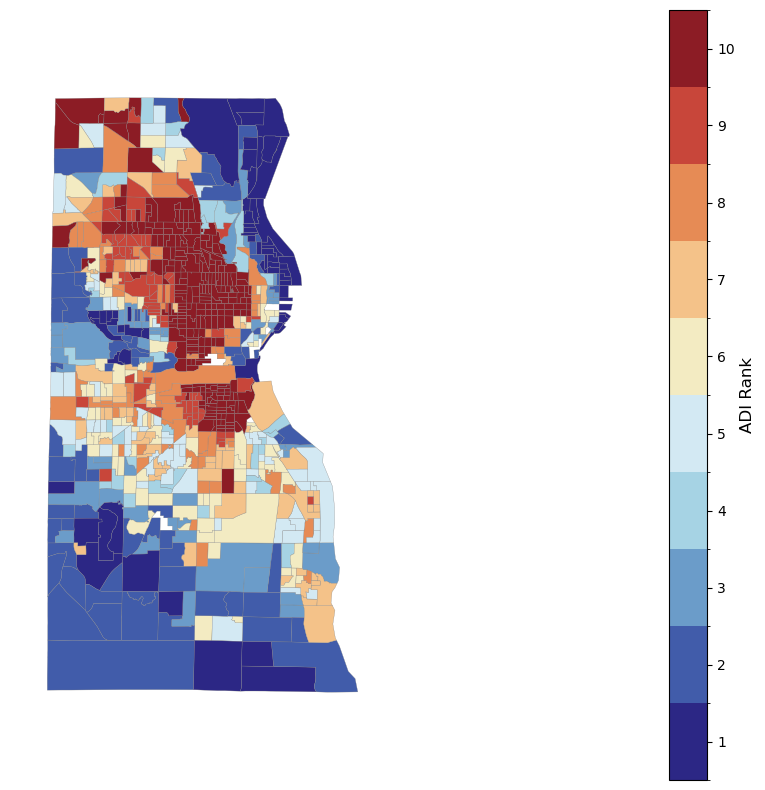

In [43]:
# plot the ADI value 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import numpy as np

# Your custom ADI colors from least (1) to most disadvantaged (10)
adi_colors = [
    "#2c2785", "#415caa", "#6b9cc9", "#a6d3e4", "#d3e9f3",  # 1–5 (blue shades)
    "#f3ebc2", "#f4c289", "#e68b55", "#c8463a", "#8c1c25"   # 6–10 (orange → red)
]

# Create ListedColormap and norm
adi_cmap = mcolors.ListedColormap(adi_colors)
boundaries = np.arange(0.5, 10.6, 1)  # Edges between 1-10
norm = mcolors.BoundaryNorm(boundaries, ncolors=10)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merge_deletNoneNum.plot(
    column="ADI_STATERNK",
    cmap=adi_cmap,
    norm=norm,
    ax=ax,
    edgecolor='gray',
    linewidth=0.2
)

# Custom colorbar
cbar = plt.cm.ScalarMappable(cmap=adi_cmap, norm=norm)
cbar.set_array([])

# Add colorbar manually with correct ticks
cb = fig.colorbar(cbar, ax=ax, boundaries=boundaries, ticks=np.arange(1, 11))
cb.set_label("ADI Rank", fontsize=12)
cb.ax.tick_params(labelsize=10)

ax.axis("off")
ax.set_xlim(-88.1, -87.6)

plt.show()


/Users/Wanting/miniforge3/envs/geoenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/9h/h1kjxm6j26ggb2qml3vbbxg80000gs/T/ipykernel_20441/943897292.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zcta = zcta[zcta.intersects(merge_plot.unary_union)]


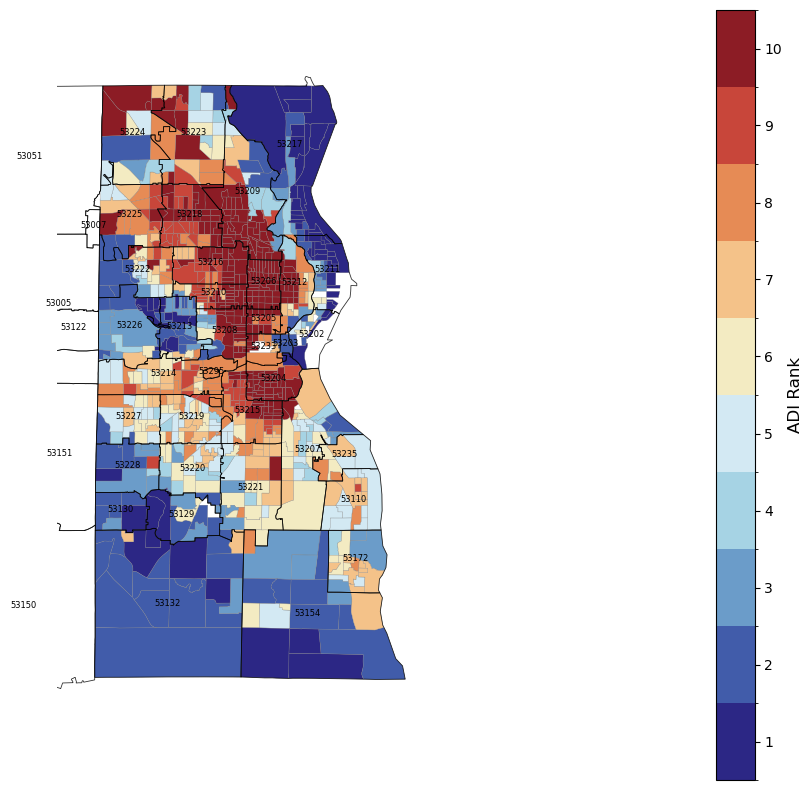

In [41]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import numpy as np

# === Load your base GeoDataFrame ===
merge_deletNoneNum["ADI_STATERNK"] = pd.to_numeric(
    merge_deletNoneNum["ADI_STATERNK"], errors="coerce"
).astype("Int64")
merge_plot = merge_deletNoneNum.dropna(subset=["ADI_STATERNK"])

# === Load ZIP shapefile ===
zcta = gpd.read_file("MKE_bin/tl_2020_us_zcta510/tl_2020_us_zcta510.shp")
zcta = zcta.to_crs(merge_plot.crs)
zcta = zcta[zcta.intersects(merge_plot.unary_union)]
exclude_zips = ["53092", "53097", "53108", "53402", "53126","53022"]
zcta = zcta[~zcta["ZCTA5CE10"].isin(exclude_zips)]


# === Define ADI color map ===
adi_colors = [
    "#2c2785", "#415caa", "#6b9cc9", "#a6d3e4", "#d3e9f3",
    "#f3ebc2", "#f4c289", "#e68b55", "#c8463a", "#8c1c25"
]
adi_cmap = mcolors.ListedColormap(adi_colors)
boundaries = np.arange(0.5, 11.5, 1)
norm = mcolors.BoundaryNorm(boundaries, ncolors=10)

# === Plotting ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merge_plot.plot(
    column="ADI_STATERNK",
    cmap=adi_cmap,
    norm=norm,
    ax=ax,
    edgecolor='gray',
    linewidth=0.2
)

# ZIP Code boundaries
zcta.boundary.plot(ax=ax, edgecolor="black", linewidth=0.6, alpha=0.8)

# Optional: Label ZIP Codes
for idx, row in zcta.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["ZCTA5CE10"],  # or ZCTA5CE20 depending on your file
        fontsize=6, ha='center', color='black'
    )

# Colorbar
cbar = plt.cm.ScalarMappable(cmap=adi_cmap, norm=norm)
cbar.set_array([])
cb = fig.colorbar(cbar, ax=ax, boundaries=boundaries, ticks=np.arange(1, 11))
cb.set_label("ADI Rank", fontsize=12)
cb.ax.tick_params(labelsize=10)

ax.axis("off")
ax.set_xlim(-88.1, -87.6)
plt.savefig("milwaukee_adi_zip_map.png", dpi=300, bbox_inches="tight")

plt.show()
